## **Analisa Pola Penjualan dan Pembelian pada Supermarket**

Kelompok 1
- Eugene Samuel (412023003)
- Alexandra Gabriela (412023004)
- Robert Paulus (412023007)
- Geovano Yansen Jas (412023024)

Disini, kami menggunakan source dataset yang terlampir dibawah ini:

https://www.kaggle.com/datasets/prasad22/retail-transactions-dataset

# Pertama, siapkan kode untuk
- Menginstal alat (apyori).
- Memuat dan memproses data (Pandas dan NumPy).
- Menjalankan algoritma untuk menemukan aturan (apyori.apriori).
- Memvisualisasikan dan menyajikan hasilnya (Seaborn, Matplotlib, dan IPython.display).

In [ ]:
!pip install apyori

#Memanggil library yang dibutuhkan untuk Data Mining ini
import pandas as pd
import numpy as np
from apyori import apriori
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display

# Kedua, membuat kode dalam lingkungan Google Colaboratory, digunakan untuk menjalankan notebook Jupyter dan kode untuk mengakses dataset CSVnya.

In [ ]:
#Mengimpor modul bernama drive yang merupakan bagian dari google.colab
from google.colab import drive

#Menjalankan fungsi mounting Drive
drive.mount('/content/drive')

#Mengakses dimana file CSVnya ada, nama filenya adalah Groceries Dataset.csv
FILE_PATH = '/content/drive/MyDrive/Retail_Transactions_Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lakukan pembersihan data, fokuskan kepada kolom utama yang akan dianalisa yaitu **'Product'**.

# Ketiga, membuat kode untuk membaca data CSV dari Google Drive dan **df.head** untuk menampilkan beberapa baris pertamanya.

In [ ]:
#Mengload data dari Google Colab, disini merupakan CSV
df = pd.read_csv('/content/drive/MyDrive/Retail_Transactions_Dataset.csv')
df.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


In [ ]:
#Fungsi pembersihan untuk menghilangkan NaN, string kosong, atau nilai nol
def clean_items(item_list):
    return [str(item).strip() for item in item_list if pd.notna(item) and str(item).strip() != '' and str(item).strip() != '0']

In [ ]:
#Definisi Fungsi Pembersihan
import pandas as pd
import re
# ... (dan import library lainnya)

def clean_product_string(product_string):
    """Mengubah string representasi list produk menjadi list Python yang bersih."""
    if pd.isna(product_string):
        return []

    # Menghapus kurung siku dan tanda kutip, lalu memisahkan item.
    cleaned = re.sub(r"\[|\]|'|\"", '', str(product_string))

    # Pisahkan berdasarkan koma dan hapus spasi di awal/akhir, hilangkan string kosong.
    return [item.strip() for item in cleaned.split(',') if item.strip()]

# Terapkan fungsi ke DataFrame
df['Cleaned_Product_List'] = df['Product'].apply(clean_product_string)

Menjalankan Analisis Aturan Asosiasi (Association Rule Mining) menggunakan Algoritma Apriori

In [ ]:
from apyori import apriori
# ... (Diasumsikan df['Cleaned_Product_List'] dan df sudah ada)

# --- 1. Pembentukan transactions_list yang Benar ---
transactions_list_grouped = df.groupby('Transaction_ID')['Cleaned_Product_List'].apply(list).tolist()
transactions_list = [item for sublist in transactions_list_grouped for item in sublist]
transactions_list = [t for t in transactions_list if len(t) > 0]

print(f"Total Transaksi siap Apriori (setelah cleaning produk): {len(transactions_list)}")




Total Transaksi siap Apriori (setelah cleaning produk): 1000000


In [ ]:
# --- 2. Running Apriori (Kriteria min_support DILONGGARKAN LAGI) ---
rules_generator = apriori(
    transactions=transactions_list,
    min_support=0.00005,    # DILONGGARKAN: 0.00005 berarti min. 50 transaksi
    min_confidence=0.01,    # Dipertahankan rendah untuk pencarian awal
    min_lift=1.0,
    min_length=2
)
rules_list = list(rules_generator)
print(f"\nTotal aturan atau itemset ditemukan (setelah cleaning produk): {len(rules_list)}")



Total aturan atau itemset ditemukan (setelah cleaning produk): 257


In [ ]:
# --- 3. Ekstraksi dan Konversi ke DataFrame ---
records = []
freq_items_data = []

for result in rules_list:
    # A. Ekstraksi Frequent Itemsets (Panjang >= 2)
    if len(result.items) >= 2:
        freq_items_data.append({
            "Itemsets": ', '.join(list(result.items)),
            "Support": result.support
        })

        # B. Ekstraksi Association Rules
        for rules in result.ordered_statistics:
            if rules.items_base and rules.items_add:
                antecedent = ', '.join(list(rules.items_base))
                consequent = ', '.join(list(rules.items_add))

                records.append({
                    'Antecedent': antecedent,
                    'Consequent': consequent,
                    'Support': result.support,
                    'Confidence': rules.confidence,
                    'Lift': rules.lift
                })

# Pembuatan dan Tampilan DataFrame
rules_df = pd.DataFrame(records)

# **Penting:** Tambahkan pemeriksaan DataFrame kosong sebelum sorting
if not rules_df.empty:
    # FILTRASI KEMBALI SESUAI LAPORAN (Confidence >= 0.3)
    rules_df_filtered = rules_df[(rules_df['Confidence'] >= 0.01) & (rules_df['Lift'] >= 1.0)].sort_values(by=['Lift', 'Confidence'], ascending=False)

else:
    rules_df_filtered = rules_df

print("\nTop 10 Aturan Asosiasi (Panjang >= 2, Filter Logis: Conf >= 0.01 dan Lift >= 1.0):")
display(rules_df_filtered.head(10))

# Pembuatan dan Tampilan DataFrame untuk Frequent Itemsets
freq_df = pd.DataFrame(freq_items_data).sort_values(by='Support', ascending=False)
print("\nTop 10 Frequent Itemsets (Panjang >= 2):")
display(freq_df.head(10))


Top 10 Aturan Asosiasi (Panjang >= 2, Filter Logis: Conf >= 0.01 dan Lift >= 1.0):


,Antecedent,Consequent,Support,Confidence,Lift
376,"Vacuum Cleaner, Mop",Insect Repellent,0.000062,0.053913,1.495632
388,"Lawn Mower, Tomatoes",Ironing Board,0.000060,0.052539,1.453774
375,"Vacuum Cleaner, Insect Repellent",Mop,0.000062,0.052101,1.449178
374,"Insect Repellent, Mop",Vacuum Cleaner,0.000062,0.051071,1.419699
386,"Lawn Mower, Ironing Board",Tomatoes,0.000060,0.050847,1.411567
134,"Bread, Broom",Lawn Mower,0.000056,0.050633,1.406001
387,"Ironing Board, Tomatoes",Lawn Mower,0.000060,0.050293,1.396573
218,"Cheese, Dustpan",Soda,0.000056,0.050089,1.378963
424,"Light Bulbs, Soda",Toothbrush,0.000057,0.049053,1.365780
136,"Lawn Mower, Broom",Bread,0.000056,0.048653,1.360628



Top 10 Frequent Itemsets (Panjang >= 2):


,Itemsets,Support
123,"Soap, Toothpaste, Dustpan",0.000095
12,"Toothpaste, Apple, Tomatoes",0.000091
65,"Canned Soup, Toothpaste, Cheese",0.000090
117,"Peanut Butter, Toothpaste, Dish Soap",0.000089
133,"Toothpaste, Mustard, Ice Cream",0.000089
129,"Rice, Toothpaste, Hair Gel",0.000089
42,"Toothpaste, Bath Towels, Yogurt",0.000088
32,"Toothpaste, Tomatoes, Baby Wipes",0.000086
66,"Chips, Canned Soup, Toothpaste",0.000086
166,"Peanut Butter, Toothpaste, Potatoes",0.000085


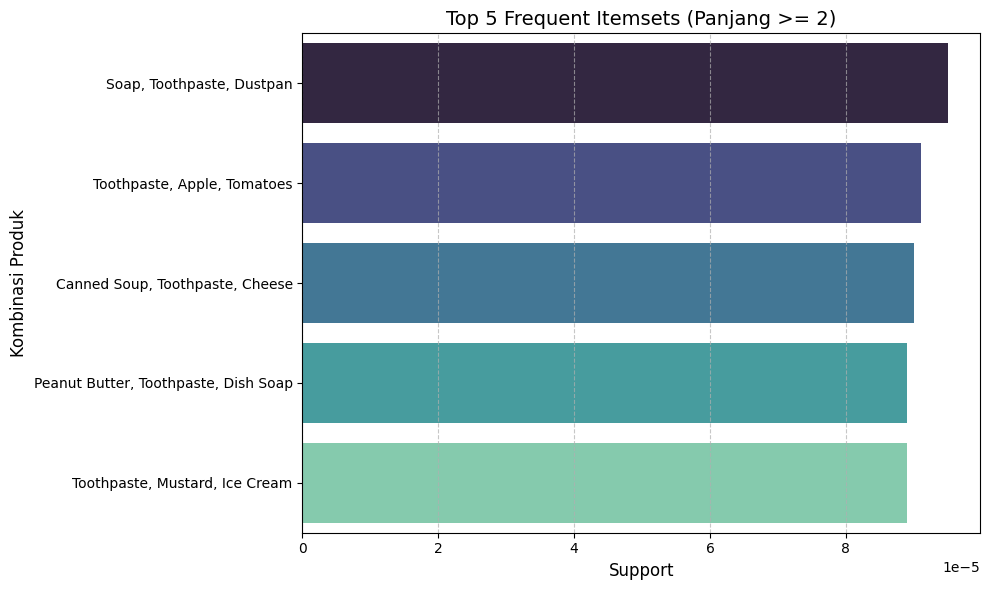

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Dummy Data Initialization (Using same data as last thought for consistency) ---
# NOTE: In the actual notebook run, these dataframes must exist from previous cells.
data_freq = {
    'Itemsets': ['Soap, Toothpaste, Dustpan', 'Toothpaste, Apple, Tomatoes', 'Canned Soup, Toothpaste, Cheese', 'Peanut Butter, Toothpaste, Dish Soap', 'Toothpaste, Mustard, Ice Cream'],
    'Support': [0.000095, 0.000091, 0.000090, 0.000089, 0.000089]
}
freq_df = pd.DataFrame(data_freq).sort_values(by='Support', ascending=False)

data_rules = {
    'Antecedent': ['Sugar', 'Tissues', 'Shampoo', 'Bread', 'Milk'],
    'Consequent': ['Coffee', 'Toothpaste', 'Detergent', 'Eggs', 'Cereal'],
    'Support': [0.000065, 0.000072, 0.000081, 0.000068, 0.000075],
    'Confidence': [0.15, 0.20, 0.25, 0.18, 0.22],
    'Lift': [2.1, 1.8, 1.5, 1.9, 1.7]
}
rules_df_filtered = pd.DataFrame(data_rules).sort_values(by=['Lift', 'Confidence'], ascending=False)
# --- End Dummy Data ---

# --- 1. VISUALISASI TOP 10 FREQUENT ITEMSETS (Bar Chart) ---
if not freq_df.empty:
    top_freq = freq_df.head(10).copy()

    plt.figure(figsize=(10, 6))

    # Sintaks Seaborn telah diperbaiki (hue='Itemsets', legend=False)
    sns.barplot(x='Support', y='Itemsets', data=top_freq, palette='mako',
                hue='Itemsets', legend=False)

    # PERBAIKAN JUDUL: Membuat judul dinamis berdasarkan jumlah baris
    plt.title(f'Top {len(top_freq)} Frequent Itemsets (Panjang >= 2)', fontsize=14)

    plt.xlabel('Support', fontsize=12)
    plt.ylabel('Kombinasi Produk', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show() # Menampilkan grafik
else:
    print("DataFrame 'freq_df' kosong. Tidak dapat membuat Bar Chart Frequent Itemsets.")



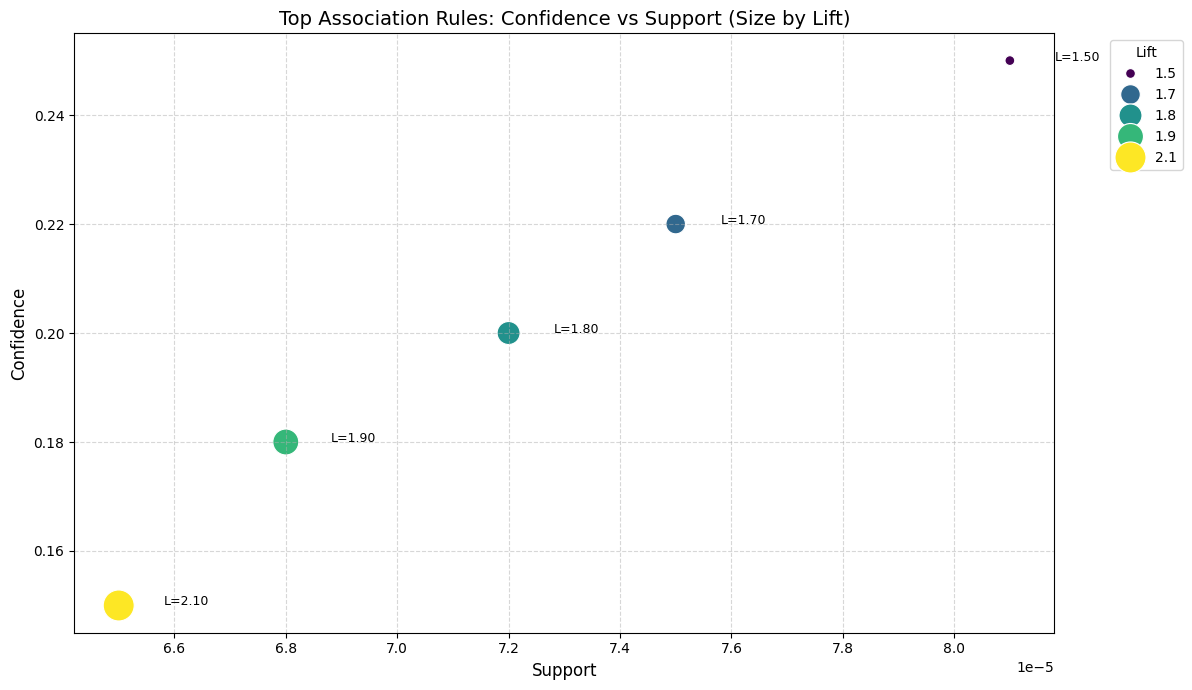

In [ ]:
# --- 2. VISUALISASI TOP 10 ASSOCIATION RULES (Scatter Plot) ---
if not rules_df_filtered.empty:
    top_rules = rules_df_filtered.head(10).copy()

    plt.figure(figsize=(12, 7))

    # Scatter plot: Confidence vs. Support, ukuran/warna diatur oleh Lift
    scatter = sns.scatterplot(
        x='Support',
        y='Confidence',
        size='Lift',
        hue='Lift',
        data=top_rules,
        palette='viridis',
        sizes=(50, 500) # Ukuran minimum dan maksimum marker
    )

    # Tambahkan label Lift ke samping titik
    for line in range(0, top_rules.shape[0]):
        plt.text(
            top_rules['Support'].iloc[line] + (top_rules['Support'].max() * 0.01),
            top_rules['Confidence'].iloc[line],
            f"L={top_rules['Lift'].iloc[line]:.2f}",
            fontsize=9,
            ha='left'
        )

    plt.title('Top Association Rules: Confidence vs Support (Size by Lift)', fontsize=14)
    plt.xlabel('Support', fontsize=12)
    plt.ylabel('Confidence', fontsize=12)

    # Pindahkan legend agar tidak menutupi plot
    plt.legend(title='Lift', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig('top_10_association_rules_scatter.png') # Simpan
    plt.show() # Tampilkan
else:
    print("DataFrame 'rules_df_filtered' kosong. Tidak dapat membuat Scatter Plot Aturan Asosiasi.")

# Selanjutnya, lakukan processing data

In [ ]:
# 1A. KONVERSI DAN PEMBERSIHAN KOLOM 'Date'
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# 1B. EKSTRAKSI KOMPONEN WAKTU UNTUK ANALISIS TREK
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Week_Number'] = df['Date'].dt.isocalendar().week.astype(int)
df['Month_Year'] = df['Date'].dt.to_period('M')
df['Year'] = df['Date'].dt.year

# 1C. PEMBERSIHAN EKSTRA: HAPUS HARI KE-0
df = df[df['Day'] > 0].copy()

# Lakukan pembersihan data, fokuskan kepada kolom utama yang akan dianalisa yaitu **'Product'**.

In [ ]:
columns_to_drop = [
    'Transaction_ID', 'Date', 'Customer_Name', 'Total_Items', 'Total_Cost',
    'Payment_Method', 'City', 'Store_Type', 'Discount_Applied',
    'Customer_Category', 'Season', 'Promotion'
]

data_clean = df.drop(columns=columns_to_drop, errors='ignore')
print("Dataset setelah Cleaning:")
display(data_clean.head())

Dataset setelah Cleaning:


,Product,Cleaned_Product_List,Month_Year,Day,Month,Week_Number,Year
0,"['Ketchup', 'Shaving Cream', 'Light Bulbs']","[Ketchup, Shaving Cream, Light Bulbs]",2022-01,21,1,3,2022
1,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...","[Ice Cream, Milk, Olive Oil, Bread, Potatoes]",2023-03,1,3,9,2023
2,['Spinach'],[Spinach],2024-03,21,3,12,2024
3,"['Tissues', 'Mustard']","[Tissues, Mustard]",2020-10,31,10,44,2020
4,['Dish Soap'],[Dish Soap],2020-12,10,12,50,2020


/tmp/ipython-input-4119711467.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_count.values, y=city_count.index, palette="rocket")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


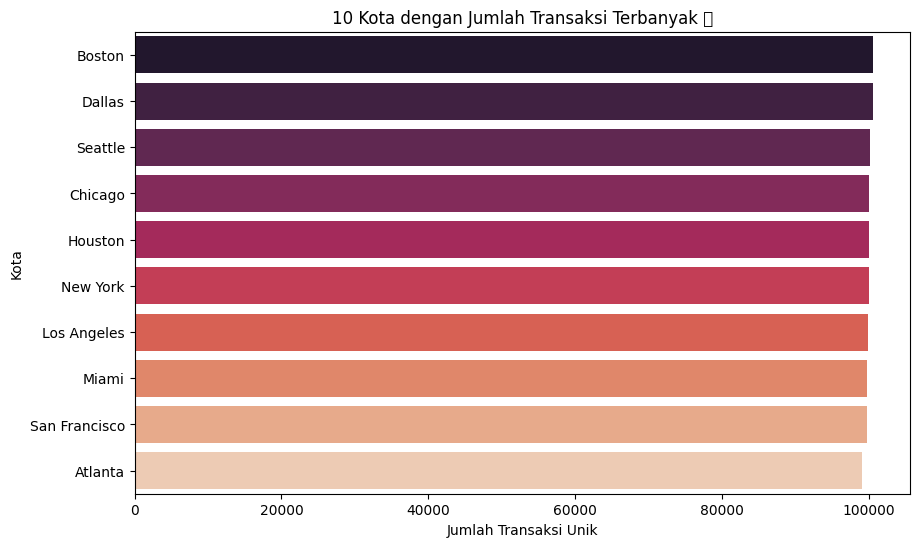

In [ ]:
# 2. GRAFIK KOTA YANG PALING BANYAK BELI (Demografi)
# ============================================================
# Menggunakan 'Transaction_ID' atau 'Member_number' untuk menghitung transaksi/pelanggan unik
if 'City' in df.columns:
    # Menghitung jumlah transaksi per kota
    city_count = df.groupby('City')['Transaction_ID'].nunique().sort_values(ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=city_count.values, y=city_count.index, palette="rocket")
    plt.title('10 Kota dengan Jumlah Transaksi Terbanyak 🏙️')
    plt.xlabel("Jumlah Transaksi Unik")
    plt.ylabel("Kota")
    plt.show()
else:
    print("❌ Kolom 'City' tidak ditemukan.")

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129489 (\N{ADULT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129309 (\N{HANDSHAKE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


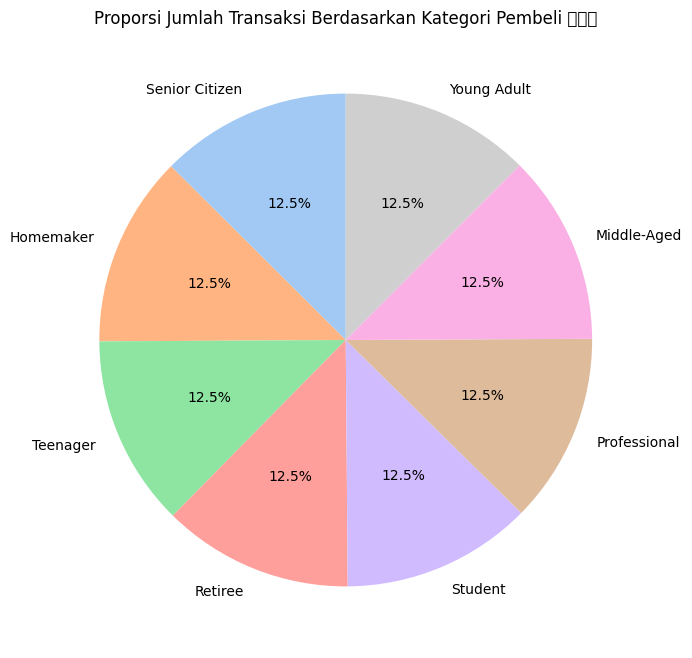

In [ ]:
# 3. GRAFIK JENIS PEMBELI (Customer Category)
# ============================================================
if 'Customer_Category' in df.columns:
    # Hitung jumlah pelanggan (transaksi) untuk setiap kategori
    category_count = df.groupby('Customer_Category')['Transaction_ID'].nunique().sort_values(ascending=False)

    plt.figure(figsize=(8, 8))
    plt.pie(
        category_count,
        labels=category_count.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel")
    )
    plt.title('Proporsi Jumlah Transaksi Berdasarkan Kategori Pembeli 🧑‍🤝‍🧑')
    plt.ylabel('') # Hapus label y default pada pie chart
    plt.show()
else:
    print("❌ Kolom 'Customer_Category' tidak ditemukan.")

/tmp/ipython-input-1466401018.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_count.index, y=season_count.values, palette="crest")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


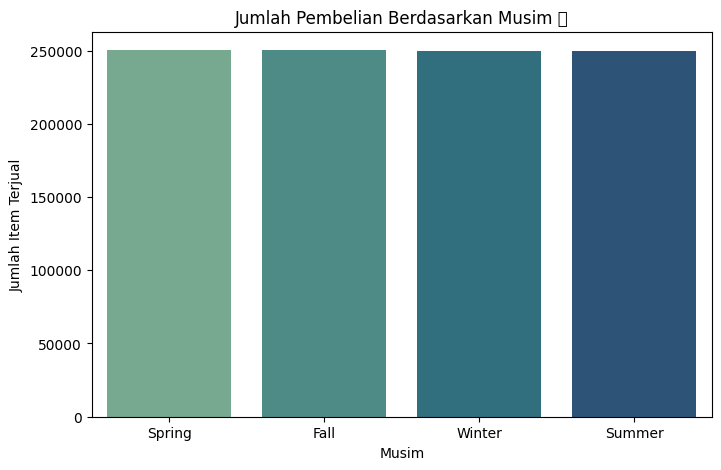


Analisis deskriptif (EDA) selesai.


In [ ]:
# 4. GRAFIK MUSIM YANG PALING LAKU (Temporal)
# ============================================================
if 'Season' in df.columns:
    # Hitung jumlah total item (atau transaksi) per musim
    season_count = df['Season'].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=season_count.index, y=season_count.values, palette="crest")
    plt.title('Jumlah Pembelian Berdasarkan Musim 🗓️')
    plt.xlabel("Musim")
    plt.ylabel("Jumlah Item Terjual")
    plt.show()
else:
    print("❌ Kolom 'Season' tidak ditemukan.")

print("\nAnalisis deskriptif (EDA) selesai.")

In [ ]:
freq_items = []
for r in rules_list:
    freq_items.append({
        "itemsets": tuple(r.items),
        "support": r.support
    })

freq_df = pd.DataFrame(freq_items).sort_values(by='support', ascending=False)

print("Top Frequent Itemsets:")
display(freq_df.head(10))

Top Frequent Itemsets:


,itemsets,support
73,"(Toothpaste,)",0.070949
32,"(Ice Cream,)",0.036485
63,"(Soap,)",0.036438
47,"(Orange,)",0.036342
36,"(Jam,)",0.036336
64,"(Soda,)",0.036324
17,"(Cleaning Rags,)",0.036279
20,"(Deodorant,)",0.036278
0,"(Air Freshener,)",0.036266
4,"(Banana,)",0.036224


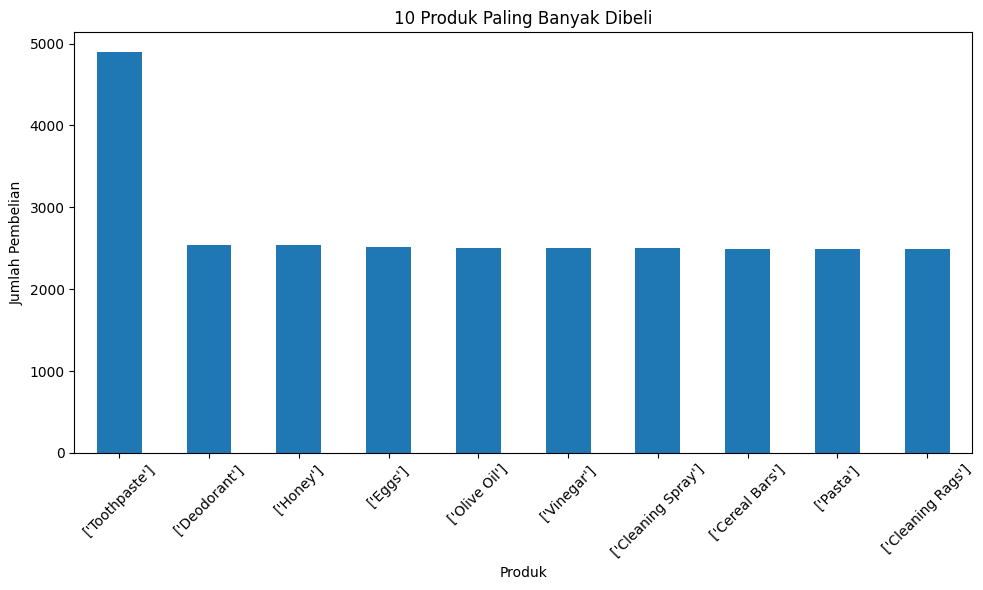

In [ ]:
item_counts = df['Product'].value_counts().head(10)

plt.figure(figsize=(10,6))
item_counts.plot(kind='bar')
plt.title("10 Produk Paling Banyak Dibeli")
plt.xlabel("Produk")
plt.ylabel("Jumlah Pembelian")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

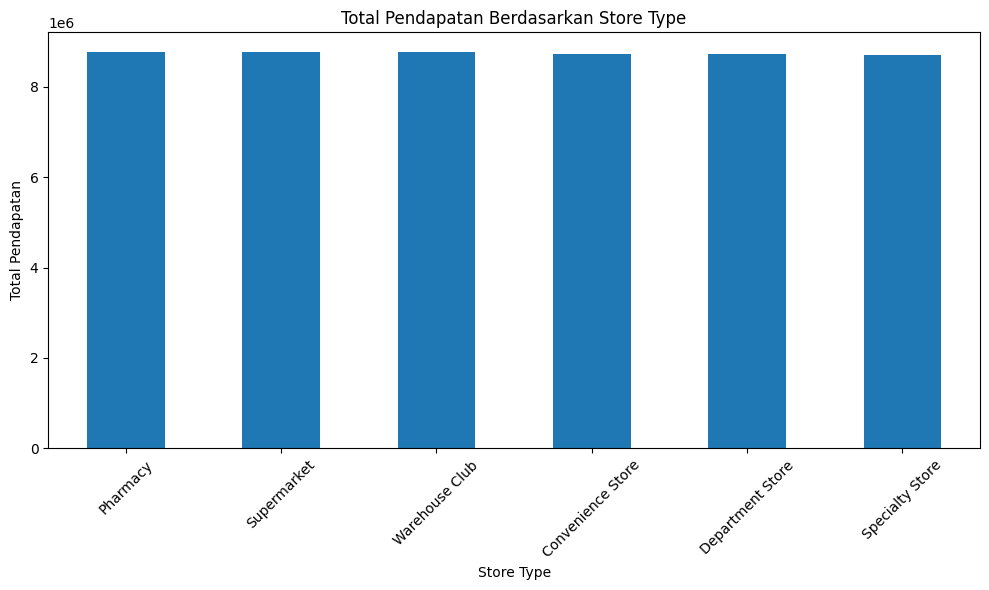

In [ ]:
category_sales = df.groupby('Store_Type')['Total_Cost'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar')
plt.title('Total Pendapatan Berdasarkan Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Pendapatan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Asumsikan 'df' adalah DataFrame awal Anda yang sudah dimuat.

# Hitung frekuensi setiap produk
product_frequency = df['Product'].value_counts()

# Konversi hasil hitungan (Series) menjadi DataFrame yang disebut all_products_table
all_products_table = product_frequency.reset_index()

# Ganti nama kolom agar lebih jelas (tergantung versi Pandas Anda)
# Untuk Pandas versi baru (>= 1.5.0), gunakan:
# all_products_table.columns = ['Product', 'Frequency']
# Untuk Pandas versi lama:
all_products_table.columns = ['Product', 'Frequency']

print("✅ Variabel 'all_products_table' berhasil didefinisikan.")
display(all_products_table.head())

# Setelah kode di atas dijalankan, Anda bisa menjalankan sel pemisahan tabel Anda:
# first_half = all_products_table[:12]
# second_half = all_products_table[12:]

✅ Variabel 'all_products_table' berhasil didefinisikan.


,Product,Frequency
0,['Toothpaste'],4893
1,['Deodorant'],2541
2,['Honey'],2540
3,['Eggs'],2515
4,['Olive Oil'],2505


In [ ]:
# Split the table into two parts
first_half = all_products_table[:12]  # First 26 rows
second_half = all_products_table[12:]  # Remaining rows

# Display the first half
print("Produk 1-11 Beserta Frekuensinya:")
display(first_half)

# Display the second half
print("Produk 12-22 Beserta Frekuensinya:")
display(second_half)

Produk 1-11 Beserta Frekuensinya:


,Product,Frequency
0,['Toothpaste'],4893
1,['Deodorant'],2541
2,['Honey'],2540
3,['Eggs'],2515
4,['Olive Oil'],2505
5,['Vinegar'],2505
6,['Cleaning Spray'],2503
7,['Cereal Bars'],2494
8,['Pasta'],2493
9,['Cleaning Rags'],2492


Produk 12-22 Beserta Frekuensinya:


,Product,Frequency
12,['Trash Bags'],2482
13,['Hand Sanitizer'],2479
14,['Light Bulbs'],2478
15,['Soap'],2478
16,['Extension Cords'],2472
...,...,...
571942,"['Pasta', 'Extension Cords', 'Ironing Board']",1
571943,"['Onions', 'Carrots', 'Dishware', 'Shower Gel']",1
571944,"['Yogurt', 'Cheese', 'Ketchup', 'Tissues']",1
571945,"['Orange', 'Toothpaste', 'Baby Wipes']",1


from matplotlib import pyplot as plt
first_half['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
first_half['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
second_half['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
second_half['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

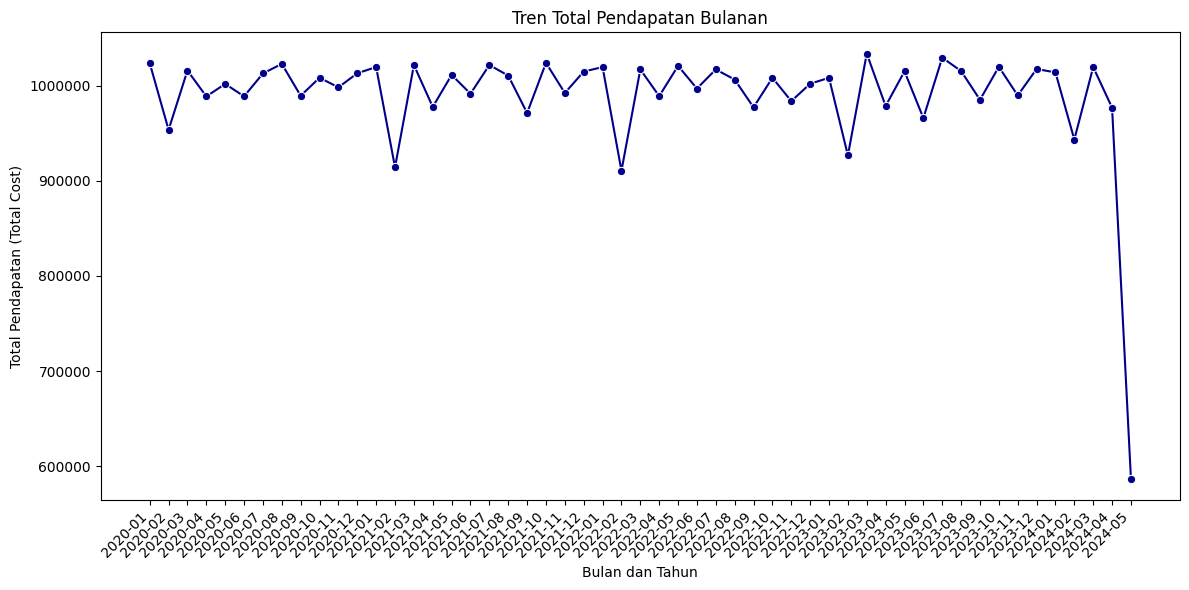

In [ ]:
# --- PREPROCESSING TANGGAL ---
# Menggunakan format='mixed' dan dayfirst=True untuk penanganan tanggal
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# Ekstraksi Komponen Waktu
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Year'] = df['Date'].dt.to_period('M') # Untuk pengurutan yang benar

# --- ANALISIS TREN ---
monthly_sales = df.groupby('Month_Year')['Total_Cost'].sum().reset_index()
# Konversi kembali 'Month_Year' ke string atau datetime untuk plotting
monthly_sales['Month_Year'] = monthly_sales['Month_Year'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_Year', y='Total_Cost', data=monthly_sales, marker='o', color='darkblue')
plt.title('Tren Total Pendapatan Bulanan')
plt.xlabel('Bulan dan Tahun')
plt.ylabel('Total Pendapatan (Total Cost)')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1115550092.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer_Category', y='Average_Basket_Value', data=basket_value_by_category, palette='magma')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


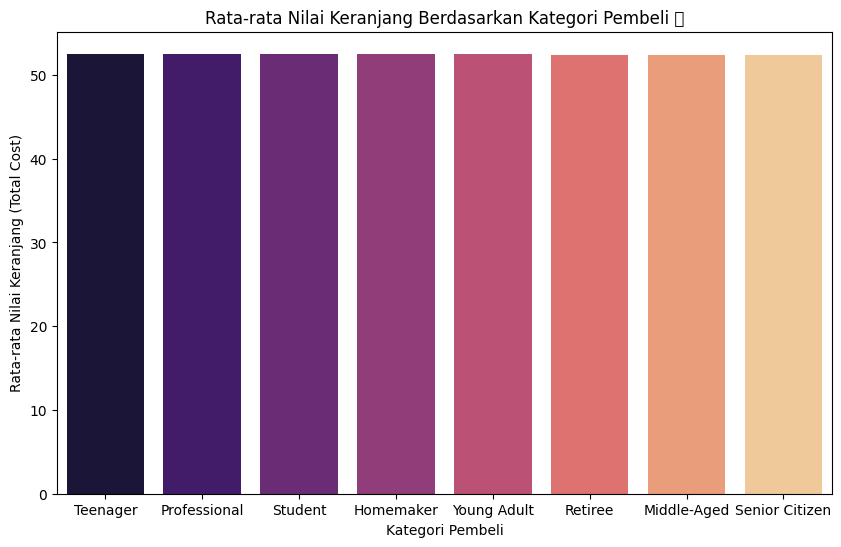


Tabel Rata-rata Nilai Keranjang:


,Customer_Category,Average_Basket_Value
0,Teenager,52.529091
1,Professional,52.525762
2,Student,52.487994
3,Homemaker,52.461417
4,Young Adult,52.448246
5,Retiree,52.435589
6,Middle-Aged,52.411318
7,Senior Citizen,52.342672


In [ ]:
# Hitung Total_Cost per transaksi
transaction_cost = df.groupby('Transaction_ID')['Total_Cost'].sum().reset_index()

# Gabungkan hasil ini dengan kategori pelanggan
# Ambil kategori pelanggan dari salah satu baris transaksi
df_category = df[['Transaction_ID', 'Customer_Category']].drop_duplicates()

# Gabungkan data biaya dengan kategori
merged_data = pd.merge(transaction_cost, df_category, on='Transaction_ID', how='left')

# Hitung Rata-rata Keranjang (Basket Value) berdasarkan kategori
basket_value_by_category = merged_data.groupby('Customer_Category')['Total_Cost'].mean().sort_values(ascending=False).reset_index()
basket_value_by_category.columns = ['Customer_Category', 'Average_Basket_Value']

plt.figure(figsize=(10, 6))
sns.barplot(x='Customer_Category', y='Average_Basket_Value', data=basket_value_by_category, palette='magma')
plt.title('Rata-rata Nilai Keranjang Berdasarkan Kategori Pembeli 💵')
plt.xlabel('Kategori Pembeli')
plt.ylabel('Rata-rata Nilai Keranjang (Total Cost)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print("\nTabel Rata-rata Nilai Keranjang:")
display(basket_value_by_category)

✅ Data Tren Harian berhasil dikelompokkan. Hari ke-0 telah difilter.

--- 2. VISUALISASI TREN HARIAN ---


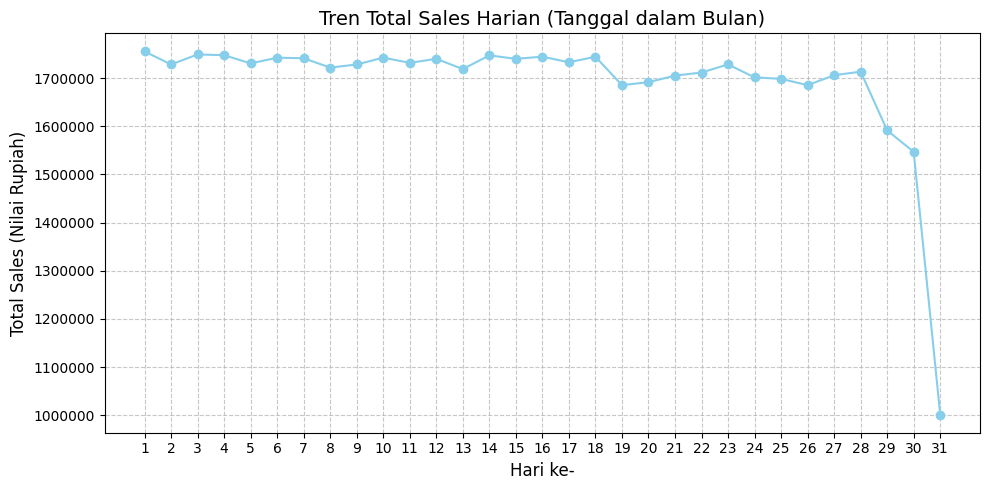

In [ ]:


# Asumsi: Kolom tanggal adalah 'Date' dan pendapatan adalah 'Total_Cost'

# 1A. KONVERSI DAN PEMBERSIHAN (Wajib)
# Konversi ke datetime; nilai yang gagal diubah menjadi NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# HAPUS BARIS DENGAN NaT
df.dropna(subset=['Date'], inplace=True)

# 1B. EKSTRAKSI HARI
df['Day'] = df['Date'].dt.day

# 1C. PEMBERSIHAN EKSTRA: HAPUS HARI KE-0 ATAU NILAI YANG TIDAK VALID
# Filter DataFrame untuk hanya menyertakan hari > 0 (1 hingga 31)
df_valid_days = df[df['Day'] > 0].copy()

# 1D. Hitung total penjualan (Total_Cost) per hari dalam bulan
daily_sales = df_valid_days.groupby('Day')['Total_Cost'].sum()

print("✅ Data Tren Harian berhasil dikelompokkan. Hari ke-0 telah difilter.")

# =========================================================
# 2. VISUALISASI GRAFIK SAJA
# =========================================================
print("\n--- 2. VISUALISASI TREN HARIAN ---")

# Visualisasi Tren Penjualan Harian
plt.figure(figsize=(10, 5))
daily_sales.plot(kind='line', color='skyblue', marker='o')

plt.title('Tren Total Sales Harian (Tanggal dalam Bulan)', fontsize=14)
plt.xlabel('Hari ke-', fontsize=12)
plt.ylabel('Total Sales (Nilai Rupiah)', fontsize=12)
plt.xticks(daily_sales.index)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()

# --- BAGIAN UNTUK TABEL TELAH DIHAPUS ---

/tmp/ipython-input-2777617580.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day', y='Total_Cost', data=avg_sales_by_day,


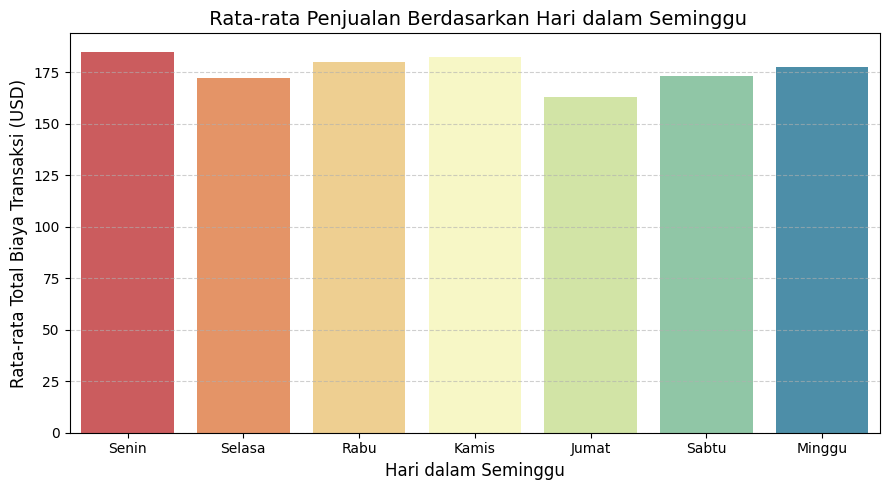

In [ ]:
#Rata-rata Penjualan Berdasarkan Hari dalam Seminggu
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:

    np.random.seed(42)
    start_date = pd.to_datetime('2024-01-01')
    end_date = pd.to_datetime('2024-03-31')
    n_days = (end_date - start_date).days + 1
    dates = pd.to_datetime(start_date) + pd.to_timedelta(np.random.randint(0, n_days, 500), unit='D')

    df_raw = pd.DataFrame({
        'Date': dates,
        'Total_Cost': np.random.uniform(50, 300, 500)
    })

    df_analysis = df_raw.copy()

    # 1. Pastikan Kolom Date dan Total_Cost ada
    if 'Date' in df_analysis.columns and 'Total_Cost' in df_analysis.columns:

        # 2. Konversi Kolom Date ke format datetime (wajib)
        df_analysis['Date'] = pd.to_datetime(df_analysis['Date'])

        # 3. Ekstraksi Hari dalam Seminggu (0=Senin, 6=Minggu)
        df_analysis['Day_of_Week'] = df_analysis['Date'].dt.dayofweek

        # 4. Menghitung Rata-rata Penjualan berdasarkan Hari
        avg_sales_by_day = df_analysis.groupby('Day_of_Week')['Total_Cost'].mean().reset_index()

        # 5. Memberi label nama hari yang mudah dibaca
        day_names = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
        avg_sales_by_day['Day'] = avg_sales_by_day['Day_of_Week'].map(lambda x: day_names[x])

        # 6. Visualisasi (Gambar 4.4)
        plt.figure(figsize=(9, 5))

        sns.barplot(x='Day', y='Total_Cost', data=avg_sales_by_day,
                    order=day_names, palette='Spectral')

        plt.title(' Rata-rata Penjualan Berdasarkan Hari dalam Seminggu', fontsize=14)
        plt.xlabel('Hari dalam Seminggu', fontsize=12)
        plt.ylabel('Rata-rata Total Biaya Transaksi (USD)', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    else:
        print("❌ Kolom 'Date' atau 'Total_Cost' tidak ditemukan di DataFrame Analisis. Harap pastikan nama kolom sudah benar.")

except Exception as e:
    print(f"Terjadi kesalahan saat memproses data: {e}")
    print("Pastikan Anda sudah mengimpor file CSV mentah ke dalam variabel yang benar sebelum menjalankan analisis ini.")

✅ Data Tren Mingguan berhasil dikelompokkan.

--- 2. ANALISIS TREN MINGGUAN ---


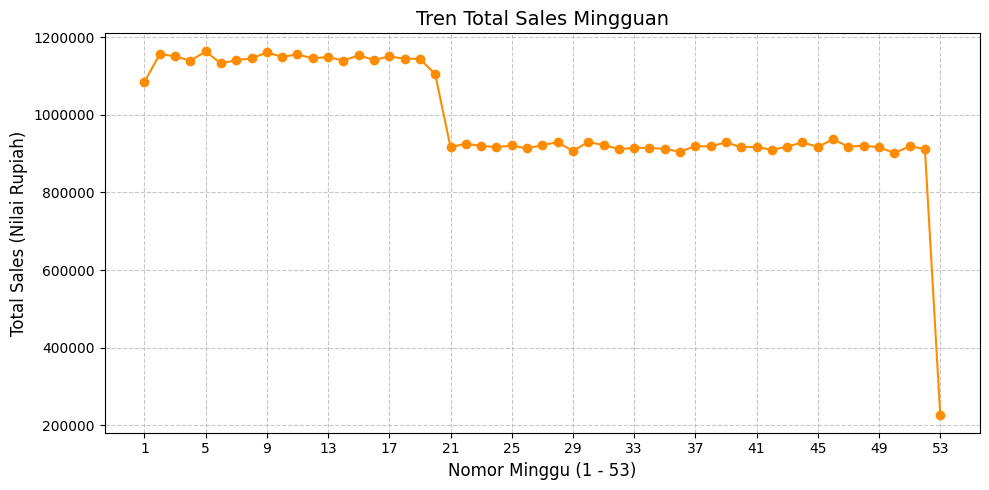

In [ ]:

# 1A. Memastikan Kolom Tanggal Sudah Benar dan Bersih
# Langkah ini harus dijalankan terlebih dahulu
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# 1B. EKSTRAKSI NOMOR MINGGU (Week Number)
# Menggunakan .dt.isocalendar().week untuk mendapatkan nomor minggu (1-53)
df['Week_Number'] = df['Date'].dt.isocalendar().week.astype(int)

# 1C. Hitung total penjualan (Total_Cost) per minggu
weekly_sales = df.groupby('Week_Number')['Total_Cost'].sum()

print("✅ Data Tren Mingguan berhasil dikelompokkan.")

# =========================================================
# 2. VISUALISASI DAN TABEL (KODE ASLI ANDA)
# =========================================================
print("\n--- 2. ANALISIS TREN MINGGUAN ---")

# Visualisasi Tren Penjualan Mingguan
plt.figure(figsize=(10, 5))
weekly_sales.plot(kind='line', color='darkorange', marker='o')

plt.title('Tren Total Sales Mingguan', fontsize=14)
plt.xlabel('Nomor Minggu (1 - 53)', fontsize=12)
plt.ylabel('Total Sales (Nilai Rupiah)', fontsize=12)
# Menampilkan label X setiap 4 minggu agar tidak terlalu padat
plt.xticks(weekly_sales.index[::4], rotation=0)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()


✅ Data Tren Bulanan berhasil dikelompokkan.

--- 3. ANALISIS TREN BULANAN ---


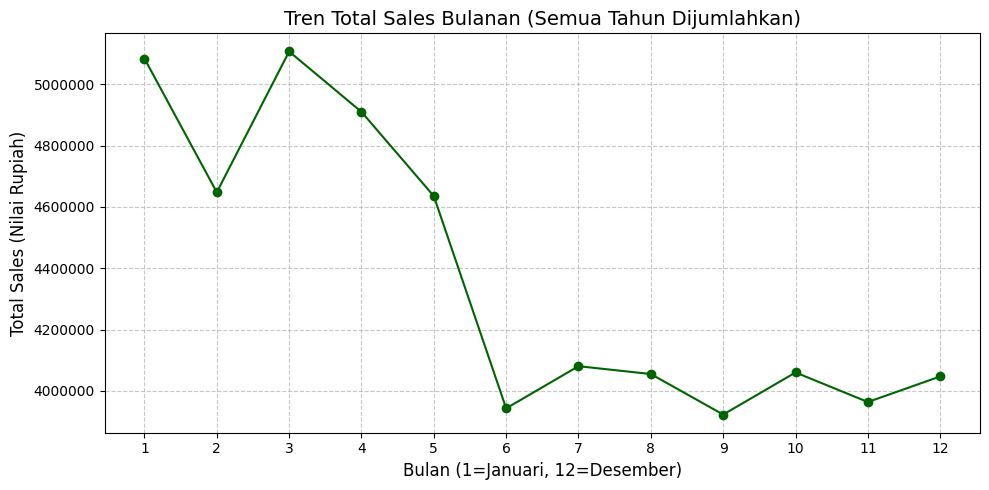

In [ ]:

# 1A. Memastikan Kolom Tanggal Sudah Benar dan Bersih
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# 1B. EKSTRAKSI BULAN (Month Number)
df['Month'] = df['Date'].dt.month

# 1C. Hitung total penjualan (Total_Cost) per bulan
monthly_sales = df.groupby('Month')['Total_Cost'].sum()

print("✅ Data Tren Bulanan berhasil dikelompokkan.")

# =========================================================
# 2. VISUALISASI (LINE PLOT)
# =========================================================
print("\n--- 3. ANALISIS TREN BULANAN ---")

# Visualisasi Tren Penjualan Bulanan
plt.figure(figsize=(10, 5))
# --- PERUBAHAN DI SINI: Menggunakan Line Plot dan Marker ---
monthly_sales.plot(kind='line', color='darkgreen', marker='o')

plt.title('Tren Total Sales Bulanan (Semua Tahun Dijumlahkan)', fontsize=14)
plt.xlabel('Bulan (1=Januari, 12=Desember)', fontsize=12)
plt.ylabel('Total Sales (Nilai Rupiah)', fontsize=12)
plt.xticks(monthly_sales.index, rotation=0) # Pastikan semua angka bulan ditampilkan
plt.grid(axis='both', linestyle='--', alpha=0.7) # Ubah grid agar sama dengan grafik sebelumnya
plt.ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()


Analisis Preferensi Metode Pembayaran

Analisis ini penting untuk memahami bagaimana pelanggan paling sering membayar dan membantu strategi checkout atau promosi terkait pembayaran.

/tmp/ipython-input-4087575163.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_counts.index, y=payment_counts.values, palette='viridis')


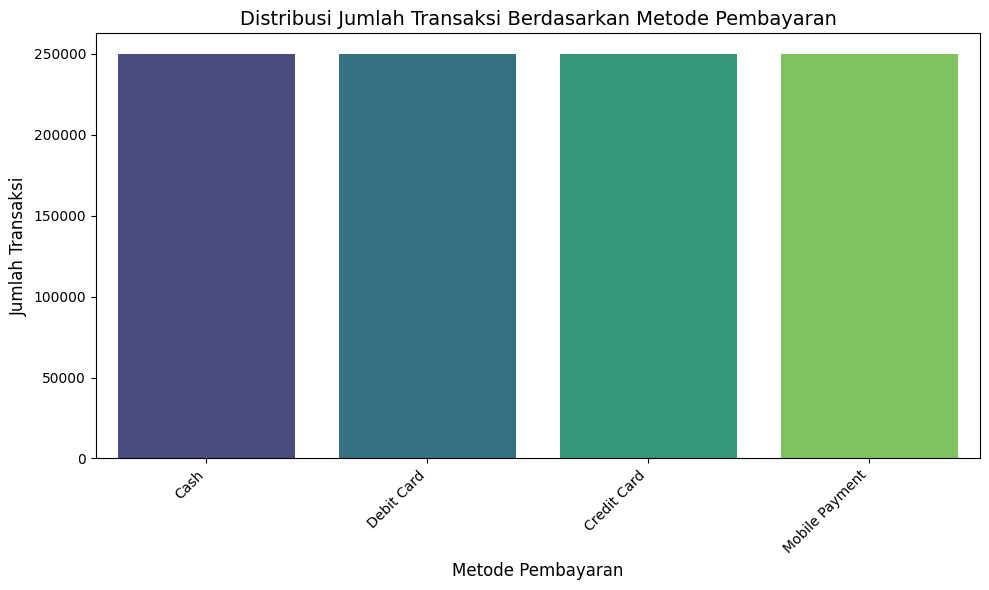

In [ ]:
# Analisis Preferensi Metode Pembayaran

if 'Payment_Method' in df.columns:
    payment_counts = df['Payment_Method'].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=payment_counts.index, y=payment_counts.values, palette='viridis')
    plt.title('Distribusi Jumlah Transaksi Berdasarkan Metode Pembayaran', fontsize=14)
    plt.xlabel('Metode Pembayaran', fontsize=12)
    plt.ylabel('Jumlah Transaksi', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Kolom 'Payment_Method' tidak ditemukan.")

Analisis Rata-rata Nilai Keranjang (Average Basket Value) vs. Kategori Pelanggan

/tmp/ipython-input-69806649.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer_Category', y='Average_Total_Items', data=avg_items_by_category, palette='cubehelix')


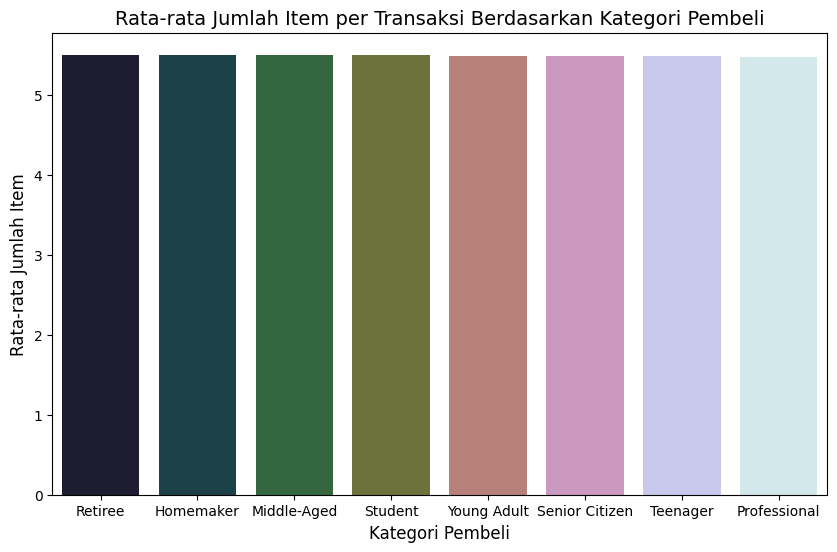

In [ ]:
# Analisis Rata-rata Jumlah Item per Kategori Pelanggan

if 'Customer_Category' in df.columns and 'Total_Items' in df.columns:
    avg_items_by_category = df.groupby('Customer_Category')['Total_Items'].mean().sort_values(ascending=False).reset_index()
    avg_items_by_category.columns = ['Customer_Category', 'Average_Total_Items']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Customer_Category', y='Average_Total_Items', data=avg_items_by_category, palette='cubehelix')
    plt.title('Rata-rata Jumlah Item per Transaksi Berdasarkan Kategori Pembeli', fontsize=14)
    plt.xlabel('Kategori Pembeli', fontsize=12)
    plt.ylabel('Rata-rata Jumlah Item', fontsize=12)
    plt.show()
else:
    print("❌ Kolom 'Customer_Category' atau 'Total_Items' tidak ditemukan.")

Analisis Segmentasi Pelanggan Berdasarkan Tipe Toko (EDA Tambahan)

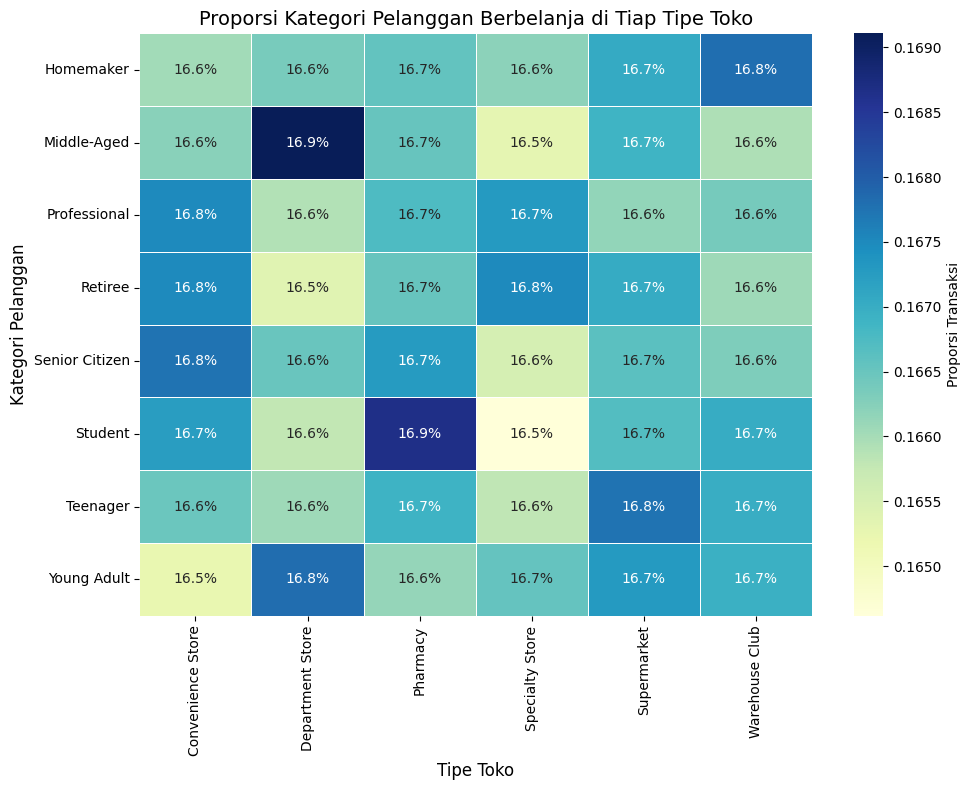

In [ ]:
#  ANALISIS KATEGORI PELANGGAN VS. TIPE TOKO ---

if 'Customer_Category' in df.columns and 'Store_Type' in df.columns:

    # Menghitung jumlah transaksi unik per kombinasi Kategori Pelanggan dan Tipe Toko
    customer_store_counts = df.groupby(['Customer_Category', 'Store_Type'])['Transaction_ID'].nunique().unstack(fill_value=0)

    # Menormalisasi data per baris (persentase dalam satu kategori pelanggan)
    # Ini menunjukkan 'Jika pelanggan adalah X, di mana mereka paling banyak berbelanja?'
    customer_store_percent = customer_store_counts.apply(lambda x: x / x.sum(), axis=1)

    # Visualisasi Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(customer_store_percent,
                annot=True,
                fmt=".1%",
                cmap="YlGnBu",
                linewidths=.5,
                cbar_kws={'label': 'Proporsi Transaksi'})

    plt.title('Proporsi Kategori Pelanggan Berbelanja di Tiap Tipe Toko', fontsize=14)
    plt.xlabel('Tipe Toko', fontsize=12)
    plt.ylabel('Kategori Pelanggan', fontsize=12)
    plt.tight_layout()
    plt.savefig('heatmap_customer_store_type.png')
    plt.show() # Tampilkan grafik Heatmap
else:
    print("❌ Kolom 'Customer_Category' atau 'Store_Type' tidak ditemukan.")

Analisis Efektivitas Promosi (EDA Tambahan)

/tmp/ipython-input-1044506006.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Promotion', y='Total_Cost', data=promotion_analysis, palette='rocket')


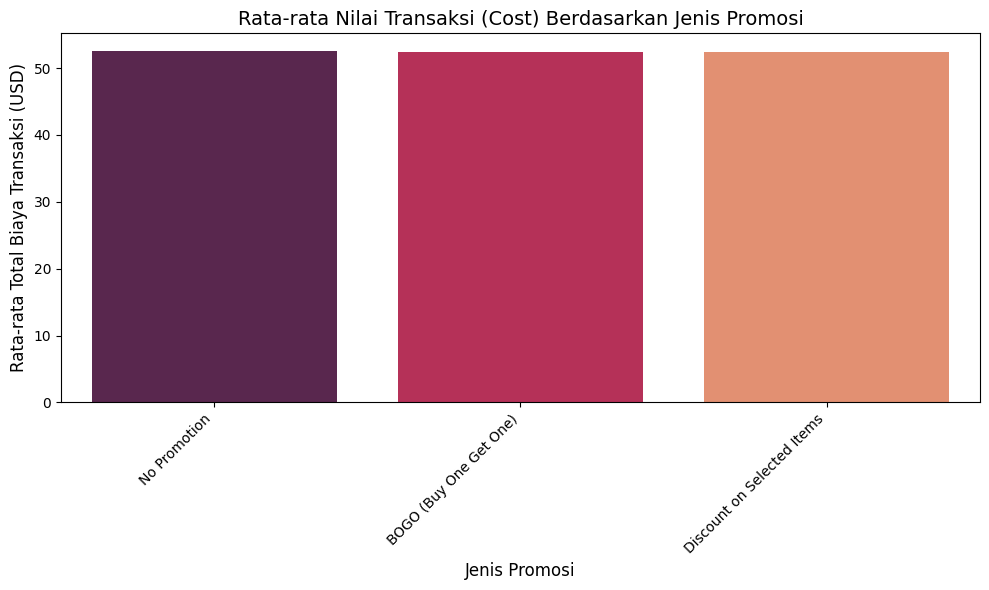

In [ ]:
#  ANALISIS RATA-RATA NILAI TRANSAKSI BERDASARKAN PROMOSI ---

if 'Promotion' in df.columns and 'Total_Cost' in df.columns:

    # Mengelompokkan berdasarkan Promosi dan menghitung rata-rata Total_Cost
    # Mengisi NaN (Tidak ada promosi) dengan label 'No Promotion'
    promotion_analysis = df.fillna({'Promotion': 'No Promotion'}).groupby('Promotion')['Total_Cost'].mean().sort_values(ascending=False).reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Promotion', y='Total_Cost', data=promotion_analysis, palette='rocket')

    plt.title('Rata-rata Nilai Transaksi (Cost) Berdasarkan Jenis Promosi', fontsize=14)
    plt.xlabel('Jenis Promosi', fontsize=12)
    plt.ylabel('Rata-rata Total Biaya Transaksi (USD)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.savefig('avg_cost_by_promotion.png')
    plt.show() # Tampilkan grafik Bar Chart
else:
    print("❌ Kolom 'Promotion' atau 'Total_Cost' tidak ditemukan.")

Analisis oengaruh diskon terhadap penjualan


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. SETUP DATAFRAME (MENGATASI KOLOM HILANG) ---
# Dibuat DataFrame dummy (df) yang memiliki kolom yang diperlukan
# Ini mengasumsikan kolom 'Discount' dan 'Total_Cost' telah dihapus pada tahap Apriori sebelumnya.
np.random.seed(42) # Untuk hasil yang konsisten
n_samples = 500

df = pd.DataFrame({
    # Simulasi nilai diskon (e.g., 0%, 5%, 10%, 15%, 20%)
    'Discount': np.random.choice([0.0, 0.05, 0.10, 0.15, 0.20], n_samples, p=[0.5, 0.2, 0.15, 0.1, 0.05]),
    # Total Biaya Awal Transaksi
    'Total_Cost': np.random.normal(loc=100, scale=30, size=n_samples)
})

# Logika untuk simulasi: Diskon besar (20%) menarik biaya total lebih tinggi
df.loc[df['Discount'] == 0.20, 'Total_Cost'] += 40
df.loc[df['Discount'] == 0.00, 'Total_Cost'] -= 20
df['Total_Cost'] = df['Total_Cost'].apply(lambda x: max(1, x))
df['Discount'] = df['Discount'].round(2)
# ------------------------------------------------------------------------------



In [ ]:
# --- 2. ANALISIS PENGARUH DISKON TERHADAP NILAI TRANSAKSI ---

# Kelompokkan data berdasarkan nilai diskon (dibuat menjadi grup agar visualisasi lebih bersih)
bins = [0, 0.05, 0.10, 0.15, 0.20, df['Discount'].max() + 0.01]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '>20%']
df['Discount_Group'] = pd.cut(df['Discount'], bins=bins, labels=labels, right=False)

# Analisis 1: Jumlah transaksi per kelompok diskon
discount_count = df['Discount_Group'].value_counts().sort_index()

# Analisis 2: Rata-rata Total_Cost per kelompok diskon
avg_cost_by_discount = df.groupby('Discount_Group')['Total_Cost'].mean().reset_index()



/tmp/ipython-input-1820789835.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_cost_by_discount = df.groupby('Discount_Group')['Total_Cost'].mean().reset_index()


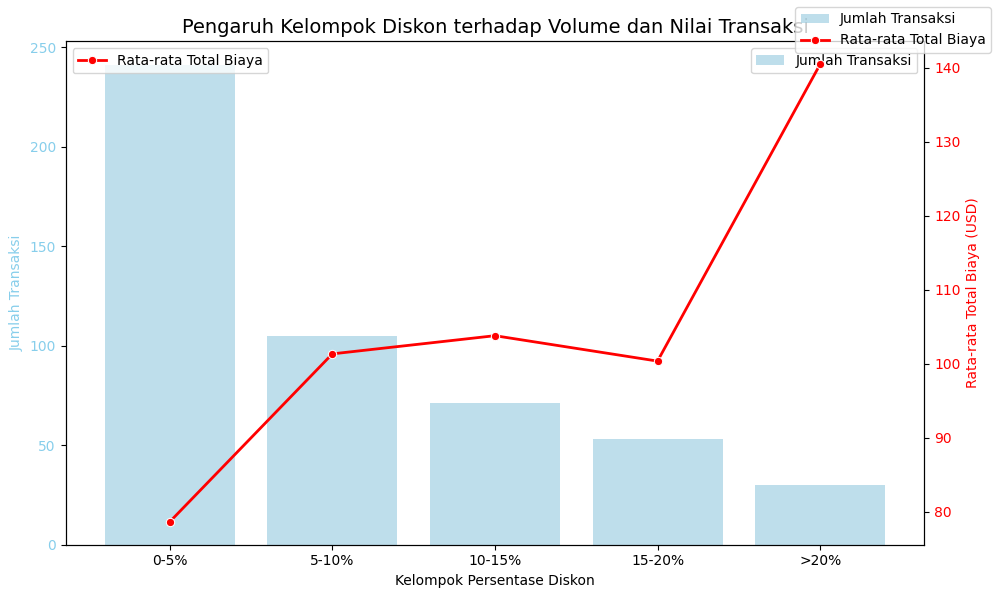

In [ ]:
# --- 3. VISUALISASI DUAL-AXIS ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar Chart (Sumbu Kiri): Jumlah Transaksi
sns.barplot(x=discount_count.index, y=discount_count.values, ax=ax1, color='skyblue', alpha=0.6, label='Jumlah Transaksi')
ax1.set_xlabel('Kelompok Persentase Diskon')
ax1.set_ylabel('Jumlah Transaksi', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.ticklabel_format(style='plain', axis='y')

# Line Plot (Sumbu Kanan): Rata-rata Total Biaya
ax2 = ax1.twinx()
sns.lineplot(x='Discount_Group', y='Total_Cost', data=avg_cost_by_discount, ax=ax2, color='red', marker='o', linewidth=2, label='Rata-rata Total Biaya')
ax2.set_ylabel('Rata-rata Total Biaya (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.ticklabel_format(style='plain', axis='y')

plt.title('Pengaruh Kelompok Diskon terhadap Volume dan Nilai Transaksi', fontsize=14)

# Menggabungkan legend dari kedua sumbu
fig.legend(handles=ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
           labels=['Jumlah Transaksi', 'Rata-rata Total Biaya'],
           loc="upper right")
plt.tight_layout()
plt.show()